### Notebook for Data transformation, preparation and model development for hourly air quality forecasting

In [2]:
pip install scikit-optimize

     |████████████████████████████████| 100 kB 9.4 MB/s 


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math

from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox 
from sklearn.preprocessing import RobustScaler

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor

from scipy.special import inv_boxcox 

from pickle import dump
from pickle import load

from sklearn.svm import SVR 
from skopt import Optimizer
from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
#from keras.optimizers import RMSprop
from keras.regularizers import l1, l2

from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras

import random

from datetime import datetime
from sklearn.model_selection import KFold, cross_val_score

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
df=pd.read_csv('Hourly_Preprocessed_Dataset.csv',index_col=0)
df.head()

,CO,NO2,OZONE,PM10,PM25,SO2,Barometric_Pressure,Dewpoint,Relative_Humidity,Temperature,Wind_Speed,season,weekend_flag,peak_hours
2015-01-02 10:00:00,-0.482597,-0.599879,-0.182026,-0.063857,-0.093282,0.005219,1.331716,-0.390781,-0.359205,-1.371250,0.224861,3,1,0
2015-01-02 11:00:00,-0.496857,-0.717961,0.095772,-0.155189,-0.093282,-0.124040,1.143620,-0.524329,-0.536764,-1.154079,-0.152468,3,1,0
2015-01-02 12:00:00,-0.513493,-0.763377,0.289706,-0.312401,0.166494,-0.253299,0.977468,-1.337763,-0.762775,-0.895541,-0.392585,3,1,0
2015-01-02 13:00:00,-0.454077,-0.708877,0.289706,-0.358815,-0.014666,-0.382557,0.914769,-1.532016,-0.777822,-0.802467,-0.907124,3,1,0
2015-01-02 14:00:00,-0.437441,-0.708877,0.394536,-0.351329,0.039597,-0.382557,0.852070,-1.871958,-0.782035,-0.750760,-0.598401,3,1,0


In [5]:
df.index= pd.to_datetime(df.index)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52574 entries, 2015-01-02 10:00:00 to 2020-12-31 23:00:00
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CO                   52574 non-null  float64
 1   NO2                  52574 non-null  float64
 2   OZONE                52574 non-null  float64
 3   PM10                 52574 non-null  float64
 4   PM25                 52574 non-null  float64
 5   SO2                  52574 non-null  float64
 6   Barometric_Pressure  52574 non-null  float64
 7   Dewpoint             52574 non-null  float64
 8   Relative_Humidity    52574 non-null  float64
 9   Temperature          52574 non-null  float64
 10  Wind_Speed           52574 non-null  float64
 11  season               52574 non-null  int64  
 12  weekend_flag         52574 non-null  int64  
 13  peak_hours           52574 non-null  int64  
dtypes: float64(11), int64(3)
memory usage: 6.0 MB


In [7]:
df.index.dtype

dtype('<M8[ns]')

In [8]:
#make sure dataset is sorted on date and hour
df.sort_index(inplace=True)

In [9]:
# load the scaler

scaler=load(open('scaler.pkl', 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
#next add lag features by converting time series to supervised.
#function to ad lead and lag features.
# convert series to supervised learning
#Reference : https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
# split data into train ,validation and test sets
def split_data(data,reshape='no',n_hours = 1, n_features = 10):
    values = data.values
    #use data for 2015-2017 for training, 2018-2019 for validation and 2020 for testing
    #train = values[:26304, :]
    train = values[:26265, :]
    #valid = values[26304:43824, :]
    valid = values[26265:43785, :]
    #test = values[43824:, :]
    test = values[43785:, :]
    # split into input and outputs
    n_obs = n_hours * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    valid_X,valid_y = valid[:, :n_obs], valid[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    if reshape=='yes':
        train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
        valid_X = valid_X.reshape((valid_X.shape[0], n_hours, n_features))
        test_X  = test_X.reshape((test_X.shape[0], n_hours, n_features))
    return train_X, train_y, valid_X, valid_y, test_X, test_y

In [12]:
#Basic structure for LSTM model
def lstm_model(train_data):
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_data.shape[1], train_data.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [13]:
##Giving error - error when time step is 1
def CNN_model(train_data):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_data.shape[1], train_data.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [14]:
#Reference https://www.nature.com/articles/s41598-020-60102-6#Sec2
def DBN(train_data,g):
    fdp=0.19+0.0025 * g
    model = Sequential()
    model.add(Conv1D(filters=24, kernel_size=5, activation='relu', input_shape=(train_data.shape[1], train_data.shape[2])))
    #model.add(MaxPooling1D(pool_size=4))
    model.add(Dropout(0.2))
    model.add(LSTM(24))
    model.add(Dropout(fdp))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model   

In [15]:
#function to calculate different error metrics for models
#references https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/
def model_evaluation(y_actual,y_predicted):
    #rmse
    rmse = math.sqrt(mean_squared_error(y_actual, y_predicted))
    #mae
    mae=mean_absolute_error(y_actual, y_predicted)
    #mape
    mape = mean_absolute_error(y_actual, y_predicted)*100
    #r2
    r2=r2_score(y_actual, y_predicted)
    return rmse, mae, mape,r2

## PM10 Forecasting

## PM10 Machine Learning Models

In [86]:
df_PM10=df.iloc[:,[3,0,1,2,4,5,10]] # continue with 7 features for all models
#df_PM10=df.iloc[:,[3,0,1,4,6,10]]#0.493 with rf
df_PM10.head()

,PM10,CO,NO2,OZONE,PM25,SO2,Wind_Speed
2015-01-02 10:00:00,-0.063857,-0.482597,-0.599879,-0.182026,-0.093282,0.005219,0.224861
2015-01-02 11:00:00,-0.155189,-0.496857,-0.717961,0.095772,-0.093282,-0.124040,-0.152468
2015-01-02 12:00:00,-0.312401,-0.513493,-0.763377,0.289706,0.166494,-0.253299,-0.392585
2015-01-02 13:00:00,-0.358815,-0.454077,-0.708877,0.289706,-0.014666,-0.382557,-0.907124
2015-01-02 14:00:00,-0.351329,-0.437441,-0.708877,0.394536,0.039597,-0.382557,-0.598401


In [87]:
# specify the number of lag hours
n_hours = 5
n_features =7 #number of features in dataframe to be used

In [88]:
# frame as supervised learning
scaled_PM10=df_PM10.values
reframed_PM10 = series_to_supervised(scaled_PM10, n_hours, 1)
print(reframed_PM10.shape)

(52569, 42)


In [89]:
#Try this
def split_ml(data,n_hours = 1, n_features = 10):
    values = data.values
    #use data for 2015-2017 for training, 2018-2019 for validation and 2020 for testing

    train = values[:43785, :]

    test = values[43785:, :]
    # split into input and outputs
    n_obs = n_hours * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]

    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    
    return train_X, train_y, test_X, test_y

In [91]:
#PM10:
PM10_train_X, PM10_train_y, PM10_test_X, PM10_test_y=split_ml(reframed_PM10,n_hours=n_hours,n_features=n_features) #for lstm 3d data is required

print("training data CO:",PM10_train_X.shape, len(PM10_train_X), PM10_train_y.shape)
print("testing data CO:",PM10_test_X.shape, len(PM10_test_X), PM10_test_y.shape)

training data CO: (43785, 35) 43785 (43785,)
testing data CO: (8784, 35) 8784 (8784,)


In [ ]:
#RF Bayes optimization

# Define the hyperparameter configuration space
rf_params = {
    'n_estimators': Integer(10,100),
    "max_features":Integer(1,13),
    'max_depth': Integer(5,50),
    "min_samples_split":Integer(2,11),
    "min_samples_leaf":Integer(1,11),
    "criterion":['mse','mae']
}
clf = RandomForestRegressor(random_state=42)

Bayes = BayesSearchCV(clf, rf_params,cv=3,n_iter=20,verbose=2, scoring='neg_mean_squared_error') 
#number of iterations is set to 20, you can increase this number if time permits
Bayes.fit(PM10_train_X, PM10_train_y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mae, max_depth=38, max_features=12, min_samples_leaf=4, min_samples_split=8, n_estimators=47 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mae, max_depth=38, max_features=12, min_samples_leaf=4, min_samples_split=8, n_estimators=47, total=11.2min
[CV] criterion=mae, max_depth=38, max_features=12, min_samples_leaf=4, min_samples_split=8, n_estimators=47 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.2min remaining:    0.0s


[CV]  criterion=mae, max_depth=38, max_features=12, min_samples_leaf=4, min_samples_split=8, n_estimators=47, total=10.9min
[CV] criterion=mae, max_depth=38, max_features=12, min_samples_leaf=4, min_samples_split=8, n_estimators=47 
[CV]  criterion=mae, max_depth=38, max_features=12, min_samples_leaf=4, min_samples_split=8, n_estimators=47, total=10.9min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=45, max_features=5, min_samples_leaf=11, min_samples_split=10, n_estimators=16 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 33.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mse, max_depth=45, max_features=5, min_samples_leaf=11, min_samples_split=10, n_estimators=16, total=   1.8s
[CV] criterion=mse, max_depth=45, max_features=5, min_samples_leaf=11, min_samples_split=10, n_estimators=16 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV]  criterion=mse, max_depth=45, max_features=5, min_samples_leaf=11, min_samples_split=10, n_estimators=16, total=   1.8s
[CV] criterion=mse, max_depth=45, max_features=5, min_samples_leaf=11, min_samples_split=10, n_estimators=16 
[CV]  criterion=mse, max_depth=45, max_features=5, min_samples_leaf=11, min_samples_split=10, n_estimators=16, total=   1.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mae, max_depth=46, max_features=2, min_samples_leaf=5, min_samples_split=4, n_estimators=51 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mae, max_depth=46, max_features=2, min_samples_leaf=5, min_samples_split=4, n_estimators=51, total= 2.9min
[CV] criterion=mae, max_depth=46, max_features=2, min_samples_leaf=5, min_samples_split=4, n_estimators=51 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s


[CV]  criterion=mae, max_depth=46, max_features=2, min_samples_leaf=5, min_samples_split=4, n_estimators=51, total= 2.8min
[CV] criterion=mae, max_depth=46, max_features=2, min_samples_leaf=5, min_samples_split=4, n_estimators=51 
[CV]  criterion=mae, max_depth=46, max_features=2, min_samples_leaf=5, min_samples_split=4, n_estimators=51, total= 2.8min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=13, max_features=8, min_samples_leaf=9, min_samples_split=7, n_estimators=19 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mse, max_depth=13, max_features=8, min_samples_leaf=9, min_samples_split=7, n_estimators=19, total=   2.7s
[CV] criterion=mse, max_depth=13, max_features=8, min_samples_leaf=9, min_samples_split=7, n_estimators=19 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV]  criterion=mse, max_depth=13, max_features=8, min_samples_leaf=9, min_samples_split=7, n_estimators=19, total=   2.7s
[CV] criterion=mse, max_depth=13, max_features=8, min_samples_leaf=9, min_samples_split=7, n_estimators=19 
[CV]  criterion=mse, max_depth=13, max_features=8, min_samples_leaf=9, min_samples_split=7, n_estimators=19, total=   2.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=25, max_features=7, min_samples_leaf=8, min_samples_split=10, n_estimators=75 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mse, max_depth=25, max_features=7, min_samples_leaf=8, min_samples_split=10, n_estimators=75, total=  11.4s
[CV] criterion=mse, max_depth=25, max_features=7, min_samples_leaf=8, min_samples_split=10, n_estimators=75 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s remaining:    0.0s


[CV]  criterion=mse, max_depth=25, max_features=7, min_samples_leaf=8, min_samples_split=10, n_estimators=75, total=  11.3s
[CV] criterion=mse, max_depth=25, max_features=7, min_samples_leaf=8, min_samples_split=10, n_estimators=75 
[CV]  criterion=mse, max_depth=25, max_features=7, min_samples_leaf=8, min_samples_split=10, n_estimators=75, total=  11.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=47, max_features=3, min_samples_leaf=3, min_samples_split=9, n_estimators=44 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mse, max_depth=47, max_features=3, min_samples_leaf=3, min_samples_split=9, n_estimators=44, total=   3.7s
[CV] criterion=mse, max_depth=47, max_features=3, min_samples_leaf=3, min_samples_split=9, n_estimators=44 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV]  criterion=mse, max_depth=47, max_features=3, min_samples_leaf=3, min_samples_split=9, n_estimators=44, total=   3.7s
[CV] criterion=mse, max_depth=47, max_features=3, min_samples_leaf=3, min_samples_split=9, n_estimators=44 
[CV]  criterion=mse, max_depth=47, max_features=3, min_samples_leaf=3, min_samples_split=9, n_estimators=44, total=   3.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=40, max_features=5, min_samples_leaf=10, min_samples_split=7, n_estimators=64 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mse, max_depth=40, max_features=5, min_samples_leaf=10, min_samples_split=7, n_estimators=64, total=   7.0s
[CV] criterion=mse, max_depth=40, max_features=5, min_samples_leaf=10, min_samples_split=7, n_estimators=64 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV]  criterion=mse, max_depth=40, max_features=5, min_samples_leaf=10, min_samples_split=7, n_estimators=64, total=   6.9s
[CV] criterion=mse, max_depth=40, max_features=5, min_samples_leaf=10, min_samples_split=7, n_estimators=64 
[CV]  criterion=mse, max_depth=40, max_features=5, min_samples_leaf=10, min_samples_split=7, n_estimators=64, total=   7.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=46, max_features=7, min_samples_leaf=9, min_samples_split=5, n_estimators=15 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mse, max_depth=46, max_features=7, min_samples_leaf=9, min_samples_split=5, n_estimators=15, total=   2.3s
[CV] criterion=mse, max_depth=46, max_features=7, min_samples_leaf=9, min_samples_split=5, n_estimators=15 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  criterion=mse, max_depth=46, max_features=7, min_samples_leaf=9, min_samples_split=5, n_estimators=15, total=   2.2s
[CV] criterion=mse, max_depth=46, max_features=7, min_samples_leaf=9, min_samples_split=5, n_estimators=15 
[CV]  criterion=mse, max_depth=46, max_features=7, min_samples_leaf=9, min_samples_split=5, n_estimators=15, total=   2.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=37, max_features=11, min_samples_leaf=5, min_samples_split=5, n_estimators=29 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mse, max_depth=37, max_features=11, min_samples_leaf=5, min_samples_split=5, n_estimators=29, total=   7.3s
[CV] criterion=mse, max_depth=37, max_features=11, min_samples_leaf=5, min_samples_split=5, n_estimators=29 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV]  criterion=mse, max_depth=37, max_features=11, min_samples_leaf=5, min_samples_split=5, n_estimators=29, total=   7.4s
[CV] criterion=mse, max_depth=37, max_features=11, min_samples_leaf=5, min_samples_split=5, n_estimators=29 
[CV]  criterion=mse, max_depth=37, max_features=11, min_samples_leaf=5, min_samples_split=5, n_estimators=29, total=   7.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mae, max_depth=42, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=35 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mae, max_depth=42, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=35, total= 7.2min
[CV] criterion=mae, max_depth=42, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=35 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.2min remaining:    0.0s


[CV]  criterion=mae, max_depth=42, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=35, total= 7.0min
[CV] criterion=mae, max_depth=42, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=35 
[CV]  criterion=mae, max_depth=42, max_features=10, min_samples_leaf=4, min_samples_split=7, n_estimators=35, total= 6.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 21.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=5, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mse, max_depth=5, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100, total=   9.2s
[CV] criterion=mse, max_depth=5, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s


[CV]  criterion=mse, max_depth=5, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100, total=   9.4s
[CV] criterion=mse, max_depth=5, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100 
[CV]  criterion=mse, max_depth=5, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100, total=   9.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mae, max_depth=50, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mae, max_depth=50, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100, total=25.0min
[CV] criterion=mae, max_depth=50, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.0min remaining:    0.0s


[CV]  criterion=mae, max_depth=50, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100, total=24.4min
[CV] criterion=mae, max_depth=50, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100 
[CV]  criterion=mae, max_depth=50, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100, total=24.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 74.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=5, max_features=13, min_samples_leaf=11, min_samples_split=11, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mse, max_depth=5, max_features=13, min_samples_leaf=11, min_samples_split=11, n_estimators=100, total=   9.3s
[CV] criterion=mse, max_depth=5, max_features=13, min_samples_leaf=11, min_samples_split=11, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[CV]  criterion=mse, max_depth=5, max_features=13, min_samples_leaf=11, min_samples_split=11, n_estimators=100, total=   9.4s
[CV] criterion=mse, max_depth=5, max_features=13, min_samples_leaf=11, min_samples_split=11, n_estimators=100 
[CV]  criterion=mse, max_depth=5, max_features=13, min_samples_leaf=11, min_samples_split=11, n_estimators=100, total=   9.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=5, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mse, max_depth=5, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=10, total=   1.0s
[CV] criterion=mse, max_depth=5, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  criterion=mse, max_depth=5, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=10, total=   1.0s
[CV] criterion=mse, max_depth=5, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=10 
[CV]  criterion=mse, max_depth=5, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=10, total=   1.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=50, max_features=13, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mse, max_depth=50, max_features=13, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=  27.9s
[CV] criterion=mse, max_depth=50, max_features=13, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.9s remaining:    0.0s


[CV]  criterion=mse, max_depth=50, max_features=13, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=  28.4s
[CV] criterion=mse, max_depth=50, max_features=13, min_samples_leaf=7, min_samples_split=2, n_estimators=100 
[CV]  criterion=mse, max_depth=50, max_features=13, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=  28.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mae, max_depth=5, max_features=13, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mae, max_depth=5, max_features=13, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=21.9min
[CV] criterion=mae, max_depth=5, max_features=13, min_samples_leaf=7, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.9min remaining:    0.0s


[CV]  criterion=mae, max_depth=5, max_features=13, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=21.4min
[CV] criterion=mae, max_depth=5, max_features=13, min_samples_leaf=7, min_samples_split=2, n_estimators=100 
[CV]  criterion=mae, max_depth=5, max_features=13, min_samples_leaf=7, min_samples_split=2, n_estimators=100, total=21.5min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 64.9min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=50, max_features=12, min_samples_leaf=11, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mse, max_depth=50, max_features=12, min_samples_leaf=11, min_samples_split=2, n_estimators=100, total=  23.4s
[CV] criterion=mse, max_depth=50, max_features=12, min_samples_leaf=11, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.4s remaining:    0.0s


[CV]  criterion=mse, max_depth=50, max_features=12, min_samples_leaf=11, min_samples_split=2, n_estimators=100, total=  23.7s
[CV] criterion=mse, max_depth=50, max_features=12, min_samples_leaf=11, min_samples_split=2, n_estimators=100 
[CV]  criterion=mse, max_depth=50, max_features=12, min_samples_leaf=11, min_samples_split=2, n_estimators=100, total=  24.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mae, max_depth=50, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mae, max_depth=50, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=10, total= 2.5min
[CV] criterion=mae, max_depth=50, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min remaining:    0.0s


[CV]  criterion=mae, max_depth=50, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=10, total= 2.4min
[CV] criterion=mae, max_depth=50, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=10 
[CV]  criterion=mae, max_depth=50, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=10, total= 2.5min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mae, max_depth=50, max_features=13, min_samples_leaf=9, min_samples_split=11, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mae, max_depth=50, max_features=13, min_samples_leaf=9, min_samples_split=11, n_estimators=100, total=24.9min
[CV] criterion=mae, max_depth=50, max_features=13, min_samples_leaf=9, min_samples_split=11, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 24.9min remaining:    0.0s


[CV]  criterion=mae, max_depth=50, max_features=13, min_samples_leaf=9, min_samples_split=11, n_estimators=100, total=24.3min
[CV] criterion=mae, max_depth=50, max_features=13, min_samples_leaf=9, min_samples_split=11, n_estimators=100 
[CV]  criterion=mae, max_depth=50, max_features=13, min_samples_leaf=9, min_samples_split=11, n_estimators=100, total=24.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 73.8min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] criterion=mse, max_depth=34, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mse, max_depth=34, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100, total=  25.1s
[CV] criterion=mse, max_depth=34, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.1s remaining:    0.0s


[CV]  criterion=mse, max_depth=34, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100, total=  25.6s
[CV] criterion=mse, max_depth=34, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100 
[CV]  criterion=mse, max_depth=34, max_features=13, min_samples_leaf=11, min_samples_split=2, n_estimators=100, total=  26.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min finished


BayesSearchCV(cv=3, error_score='raise',
              estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                              criterion='mse', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False...
                             'max_depth': Integer(low=5, high=50, prior='uniform', transform='normalize'),
   

In [ ]:
Bayes.best_params_

OrderedDict([('criterion', 'mse'),
             ('max_depth', 50),
             ('max_features', 12),
             ('min_samples_leaf', 11),
             ('min_samples_split', 2),
             ('n_estimators', 100)])

In [ ]:
Bayes.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=12, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=11,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [92]:
#fit best model with 7 features, new bayes

model_PM10 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=12, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=11,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

#Using grid search, giving less r2.
#RandomForestRegressor(max_depth=80, max_features=3, min_samples_leaf=3,
 #                     min_samples_split=8, n_estimators=200,random_state=42)


model_PM10.fit(PM10_train_X, PM10_train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=12, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=11,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [93]:
yhat=model_PM10.predict(PM10_test_X)
yhat = np.repeat(yhat.reshape(-1,1), 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,3]

In [94]:
# invert scaling for actual values
y_actual=PM10_test_y.reshape(len(PM10_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,3]

In [95]:
#Model Evaluation,bayes search random forest, 7 features
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 37.876
Test MAE: 16.629
Test MAPE: 1662.892
Test R2: 0.545


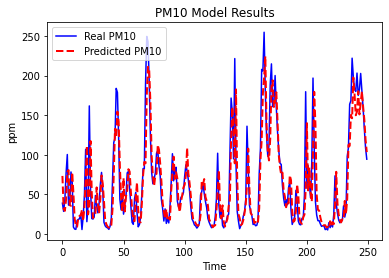

In [96]:
plt.plot(inv_y[:250], color = 'blue', label = 'Real PM10')
plt.plot(inv_yhat[:250],"--", linewidth=2,color = 'red', label = 'Predicted PM10')
plt.title('PM10 Model Results')
plt.xlabel('Time')
plt.ylabel('ppm')
plt.legend()
plt.show()

### PM 10 GBR

In [97]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.1, loss = "huber", 
                                random_state = 42, n_iter_no_change = 20)

gbr.fit(PM10_train_X, PM10_train_y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=20, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [98]:
yhat=gbr.predict(PM10_test_X)
yhat = np.repeat(yhat.reshape(-1,1), 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,3]

In [99]:
# invert scaling for actual values
y_actual=PM10_test_y.reshape(len(PM10_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,3]

In [100]:
#Model Evaluation,
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 38.460
Test MAE: 16.421
Test MAPE: 1642.113
Test R2: 0.531


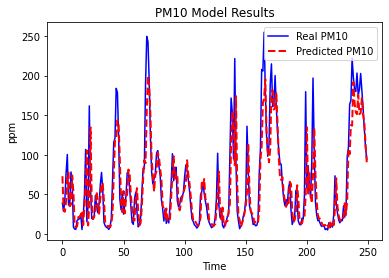

In [101]:
plt.plot(inv_y[:250], color = 'blue', label = 'Real PM10')
plt.plot(inv_yhat[:250],"--", linewidth=2,color = 'red', label = 'Predicted PM10')
plt.title('PM10 Model Results')
plt.xlabel('Time')
plt.ylabel('ppm')
plt.legend()
plt.show()

### PM10 Ensemble

**PM10 Voting Ensemble**

In [102]:
r1=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=12, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=11,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

r2=GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.1, loss = "huber", 
                                random_state = 42, n_iter_no_change = 20)


vr = VotingRegressor([('rf', r1), ('gb', r2)],weights =[3,1])

vr.fit(PM10_train_X, PM10_train_y)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=50,
                                                   max_features=12,
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=11,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                                          

In [104]:
yhat=vr.predict(PM10_test_X)
yhat = np.repeat(yhat.reshape(-1,1), 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,3]

# invert scaling for actual values
y_actual=PM10_test_y.reshape(len(PM10_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,3]

#Model Evaluation, stacking, weights two, 3 1
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 37.837
Test MAE: 16.450
Test MAPE: 1645.016
Test R2: 0.546


## PM2.5 Forecasting

**PM 2.5 Machine Learning Model**

In [133]:
df_PM25=df.iloc[:,[4,3,6,7,8,9,10]] #CNN 0.455, better
#df_PM25=df.iloc[:,[4,3,6,8,10]]
df_PM25.head()

,PM25,PM10,Barometric_Pressure,Dewpoint,Relative_Humidity,Temperature,Wind_Speed
2015-01-02 10:00:00,-0.093282,-0.063857,1.331716,-0.390781,-0.359205,-1.371250,0.224861
2015-01-02 11:00:00,-0.093282,-0.155189,1.143620,-0.524329,-0.536764,-1.154079,-0.152468
2015-01-02 12:00:00,0.166494,-0.312401,0.977468,-1.337763,-0.762775,-0.895541,-0.392585
2015-01-02 13:00:00,-0.014666,-0.358815,0.914769,-1.532016,-0.777822,-0.802467,-0.907124
2015-01-02 14:00:00,0.039597,-0.351329,0.852070,-1.871958,-0.782035,-0.750760,-0.598401


In [134]:
# specify the number of lag hours
n_hours = 5
n_features = 7 #number of features in dataframe to be used

# frame as supervised learning
scaled_PM25=df_PM25.values
reframed_PM25 = series_to_supervised(scaled_PM25, n_hours, 1)
print(reframed_PM25.shape)

#Try this
def split_ml(data,n_hours = 1, n_features = 10):
    values = data.values
    #use data for 2015-2017 for training, 2018-2019 for validation and 2020 for testing

    train = values[:43785, :]

    test = values[43785:, :]
    # split into input and outputs
    n_obs = n_hours * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]

    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    
    return train_X, train_y, test_X, test_y

#PM25:
PM25_train_X, PM25_train_y, PM25_test_X, PM25_test_y=split_ml(reframed_PM25,n_hours=n_hours,n_features=n_features) #for lstm 3d data is required

print("training data CO:",PM25_train_X.shape, len(PM25_train_X), PM25_train_y.shape)
print("testing data CO:",PM25_test_X.shape, len(PM25_test_X), PM25_test_y.shape)

(52569, 42)
training data CO: (43785, 35) 43785 (43785,)
testing data CO: (8784, 35) 8784 (8784,)


In [138]:
#RF Bayes optimization

# Define the hyperparameter configuration space
rf_params = {
    'n_estimators': Integer(10,100),
    "max_features":Integer(1,13),
    'max_depth': Integer(5,50),
    "min_samples_split":Integer(2,11),
    "min_samples_leaf":Integer(1,11)
    }
clf = RandomForestRegressor(random_state=42)

Bayes = BayesSearchCV(clf, rf_params,cv=3,n_iter=20,verbose=2, scoring='neg_mean_squared_error') 
#number of iterations is set to 20, you can increase this number if time permits
Bayes.fit(PM25_train_X, PM25_train_y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=23, max_features=10, min_samples_leaf=10, min_samples_split=5, n_estimators=70 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=23, max_features=10, min_samples_leaf=10, min_samples_split=5, n_estimators=70, total=  15.1s
[CV] max_depth=23, max_features=10, min_samples_leaf=10, min_samples_split=5, n_estimators=70 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s remaining:    0.0s


[CV]  max_depth=23, max_features=10, min_samples_leaf=10, min_samples_split=5, n_estimators=70, total=  16.2s
[CV] max_depth=23, max_features=10, min_samples_leaf=10, min_samples_split=5, n_estimators=70 
[CV]  max_depth=23, max_features=10, min_samples_leaf=10, min_samples_split=5, n_estimators=70, total=  16.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=43, max_features=12, min_samples_leaf=4, min_samples_split=11, n_estimators=88 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   47.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=43, max_features=12, min_samples_leaf=4, min_samples_split=11, n_estimators=88, total=  26.7s
[CV] max_depth=43, max_features=12, min_samples_leaf=4, min_samples_split=11, n_estimators=88 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.7s remaining:    0.0s


[CV]  max_depth=43, max_features=12, min_samples_leaf=4, min_samples_split=11, n_estimators=88, total=  28.6s
[CV] max_depth=43, max_features=12, min_samples_leaf=4, min_samples_split=11, n_estimators=88 
[CV]  max_depth=43, max_features=12, min_samples_leaf=4, min_samples_split=11, n_estimators=88, total=  29.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=25, max_features=12, min_samples_leaf=2, min_samples_split=6, n_estimators=27 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=25, max_features=12, min_samples_leaf=2, min_samples_split=6, n_estimators=27, total=   8.8s
[CV] max_depth=25, max_features=12, min_samples_leaf=2, min_samples_split=6, n_estimators=27 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


[CV]  max_depth=25, max_features=12, min_samples_leaf=2, min_samples_split=6, n_estimators=27, total=   9.4s
[CV] max_depth=25, max_features=12, min_samples_leaf=2, min_samples_split=6, n_estimators=27 
[CV]  max_depth=25, max_features=12, min_samples_leaf=2, min_samples_split=6, n_estimators=27, total=   9.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=42, max_features=3, min_samples_leaf=7, min_samples_split=9, n_estimators=57 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=42, max_features=3, min_samples_leaf=7, min_samples_split=9, n_estimators=57, total=   4.3s
[CV] max_depth=42, max_features=3, min_samples_leaf=7, min_samples_split=9, n_estimators=57 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV]  max_depth=42, max_features=3, min_samples_leaf=7, min_samples_split=9, n_estimators=57, total=   4.7s
[CV] max_depth=42, max_features=3, min_samples_leaf=7, min_samples_split=9, n_estimators=57 
[CV]  max_depth=42, max_features=3, min_samples_leaf=7, min_samples_split=9, n_estimators=57, total=   4.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=41, max_features=6, min_samples_leaf=6, min_samples_split=8, n_estimators=91 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=41, max_features=6, min_samples_leaf=6, min_samples_split=8, n_estimators=91, total=  13.4s
[CV] max_depth=41, max_features=6, min_samples_leaf=6, min_samples_split=8, n_estimators=91 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s remaining:    0.0s


[CV]  max_depth=41, max_features=6, min_samples_leaf=6, min_samples_split=8, n_estimators=91, total=  14.3s
[CV] max_depth=41, max_features=6, min_samples_leaf=6, min_samples_split=8, n_estimators=91 
[CV]  max_depth=41, max_features=6, min_samples_leaf=6, min_samples_split=8, n_estimators=91, total=  14.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=38, max_features=12, min_samples_leaf=3, min_samples_split=4, n_estimators=82 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   42.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=38, max_features=12, min_samples_leaf=3, min_samples_split=4, n_estimators=82, total=  26.7s
[CV] max_depth=38, max_features=12, min_samples_leaf=3, min_samples_split=4, n_estimators=82 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.7s remaining:    0.0s


[CV]  max_depth=38, max_features=12, min_samples_leaf=3, min_samples_split=4, n_estimators=82, total=  28.2s
[CV] max_depth=38, max_features=12, min_samples_leaf=3, min_samples_split=4, n_estimators=82 
[CV]  max_depth=38, max_features=12, min_samples_leaf=3, min_samples_split=4, n_estimators=82, total=  29.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=33, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=63 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=33, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=63, total=  15.5s
[CV] max_depth=33, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=63 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s


[CV]  max_depth=33, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=63, total=  16.6s
[CV] max_depth=33, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=63 
[CV]  max_depth=33, max_features=10, min_samples_leaf=5, min_samples_split=10, n_estimators=63, total=  17.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=29, max_features=12, min_samples_leaf=6, min_samples_split=10, n_estimators=39 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   49.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=29, max_features=12, min_samples_leaf=6, min_samples_split=10, n_estimators=39, total=  11.2s
[CV] max_depth=29, max_features=12, min_samples_leaf=6, min_samples_split=10, n_estimators=39 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[CV]  max_depth=29, max_features=12, min_samples_leaf=6, min_samples_split=10, n_estimators=39, total=  12.1s
[CV] max_depth=29, max_features=12, min_samples_leaf=6, min_samples_split=10, n_estimators=39 
[CV]  max_depth=29, max_features=12, min_samples_leaf=6, min_samples_split=10, n_estimators=39, total=  12.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=48, max_features=9, min_samples_leaf=10, min_samples_split=6, n_estimators=44 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   35.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=48, max_features=9, min_samples_leaf=10, min_samples_split=6, n_estimators=44, total=   8.8s
[CV] max_depth=48, max_features=9, min_samples_leaf=10, min_samples_split=6, n_estimators=44 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


[CV]  max_depth=48, max_features=9, min_samples_leaf=10, min_samples_split=6, n_estimators=44, total=   9.4s
[CV] max_depth=48, max_features=9, min_samples_leaf=10, min_samples_split=6, n_estimators=44 
[CV]  max_depth=48, max_features=9, min_samples_leaf=10, min_samples_split=6, n_estimators=44, total=   9.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=5, max_features=11, min_samples_leaf=8, min_samples_split=4, n_estimators=62 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, max_features=11, min_samples_leaf=8, min_samples_split=4, n_estimators=62, total=   4.6s
[CV] max_depth=5, max_features=11, min_samples_leaf=8, min_samples_split=4, n_estimators=62 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV]  max_depth=5, max_features=11, min_samples_leaf=8, min_samples_split=4, n_estimators=62, total=   4.9s
[CV] max_depth=5, max_features=11, min_samples_leaf=8, min_samples_split=4, n_estimators=62 
[CV]  max_depth=5, max_features=11, min_samples_leaf=8, min_samples_split=4, n_estimators=62, total=   5.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=50, max_features=11, min_samples_leaf=1, min_samples_split=11, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=50, max_features=11, min_samples_leaf=1, min_samples_split=11, n_estimators=100, total=  31.5s
[CV] max_depth=50, max_features=11, min_samples_leaf=1, min_samples_split=11, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.5s remaining:    0.0s


[CV]  max_depth=50, max_features=11, min_samples_leaf=1, min_samples_split=11, n_estimators=100, total=  33.8s
[CV] max_depth=50, max_features=11, min_samples_leaf=1, min_samples_split=11, n_estimators=100 
[CV]  max_depth=50, max_features=11, min_samples_leaf=1, min_samples_split=11, n_estimators=100, total=  34.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=5, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=100, total=   8.7s
[CV] max_depth=5, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV]  max_depth=5, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=100, total=   9.3s
[CV] max_depth=5, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=100 
[CV]  max_depth=5, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=100, total=   9.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=5, max_features=10, min_samples_leaf=1, min_samples_split=11, n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, max_features=10, min_samples_leaf=1, min_samples_split=11, n_estimators=10, total=   0.7s
[CV] max_depth=5, max_features=10, min_samples_leaf=1, min_samples_split=11, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=5, max_features=10, min_samples_leaf=1, min_samples_split=11, n_estimators=10, total=   0.7s
[CV] max_depth=5, max_features=10, min_samples_leaf=1, min_samples_split=11, n_estimators=10 
[CV]  max_depth=5, max_features=10, min_samples_leaf=1, min_samples_split=11, n_estimators=10, total=   0.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=44 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=44, total=  16.6s
[CV] max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=44 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.6s remaining:    0.0s


[CV]  max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=44, total=  17.9s
[CV] max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=44 
[CV]  max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=44, total=  18.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   52.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=5, max_features=10, min_samples_leaf=1, min_samples_split=11, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, max_features=10, min_samples_leaf=1, min_samples_split=11, n_estimators=100, total=   6.7s
[CV] max_depth=5, max_features=10, min_samples_leaf=1, min_samples_split=11, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV]  max_depth=5, max_features=10, min_samples_leaf=1, min_samples_split=11, n_estimators=100, total=   7.2s
[CV] max_depth=5, max_features=10, min_samples_leaf=1, min_samples_split=11, n_estimators=100 
[CV]  max_depth=5, max_features=10, min_samples_leaf=1, min_samples_split=11, n_estimators=100, total=   7.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  41.7s
[CV] max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.7s remaining:    0.0s


[CV]  max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  44.0s
[CV] max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  45.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=5, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=  39.2s
[CV] max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=5, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.2s remaining:    0.0s


[CV]  max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=  41.8s
[CV] max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=  42.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=10, total=   3.7s
[CV] max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV]  max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=10, total=   4.0s
[CV] max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=10 
[CV]  max_depth=50, max_features=13, min_samples_leaf=1, min_samples_split=11, n_estimators=10, total=   4.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=50, max_features=11, min_samples_leaf=1, min_samples_split=11, n_estimators=53 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=50, max_features=11, min_samples_leaf=1, min_samples_split=11, n_estimators=53, total=  16.7s
[CV] max_depth=50, max_features=11, min_samples_leaf=1, min_samples_split=11, n_estimators=53 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.7s remaining:    0.0s


[CV]  max_depth=50, max_features=11, min_samples_leaf=1, min_samples_split=11, n_estimators=53, total=  18.1s
[CV] max_depth=50, max_features=11, min_samples_leaf=1, min_samples_split=11, n_estimators=53 
[CV]  max_depth=50, max_features=11, min_samples_leaf=1, min_samples_split=11, n_estimators=53, total=  18.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   53.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=50, max_features=10, min_samples_leaf=1, min_samples_split=2, n_estimators=69 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=50, max_features=10, min_samples_leaf=1, min_samples_split=2, n_estimators=69, total=  22.3s
[CV] max_depth=50, max_features=10, min_samples_leaf=1, min_samples_split=2, n_estimators=69 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.3s remaining:    0.0s


[CV]  max_depth=50, max_features=10, min_samples_leaf=1, min_samples_split=2, n_estimators=69, total=  23.7s
[CV] max_depth=50, max_features=10, min_samples_leaf=1, min_samples_split=2, n_estimators=69 
[CV]  max_depth=50, max_features=10, min_samples_leaf=1, min_samples_split=2, n_estimators=69, total=  24.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min finished


BayesSearchCV(cv=3, error_score='raise',
              estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                              criterion='mse', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False...
              search_spaces={'max_depth': Integer(low=5, high=50, prior='uniform', transform='normalize'),
   

In [139]:
Bayes.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=11, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=11, min_weight_fraction_leaf=0.0,
                      n_estimators=53, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [140]:
model_PM25_rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=11, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=11, min_weight_fraction_leaf=0.0,
                      n_estimators=53, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

model_PM25_rf.fit(PM25_train_X, PM25_train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=11, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=11, min_weight_fraction_leaf=0.0,
                      n_estimators=53, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [141]:
yhat=model_PM25_rf.predict(PM25_test_X)
yhat = np.repeat(yhat.reshape(-1,1), 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,4]

# invert scaling for actual values
y_actual=PM25_test_y.reshape(len(PM25_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,4]

#Model Evaluation - 8 new set
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 4.671
Test MAE: 2.843
Test MAPE: 284.335
Test R2: 0.433


In [142]:
gbr = GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.1, loss = "huber", 
                                random_state = 42, n_iter_no_change = 20)

gbr.fit(PM25_train_X, PM25_train_y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=3, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=20, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [143]:
yhat=gbr.predict(PM25_test_X)
yhat = np.repeat(yhat.reshape(-1,1), 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,4]

# invert scaling for actual values
y_actual=PM25_test_y.reshape(len(PM25_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,4]

#Model Evaluation - 8 new set
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 4.231
Test MAE: 2.502
Test MAPE: 250.181
Test R2: 0.535


**Ensemble Voting - Best model PM 2.5**

In [156]:
r1=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features=11, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=11, min_weight_fraction_leaf=0.0,
                      n_estimators=53, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

r2=GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.1, loss = "huber", 
                                random_state = 42, n_iter_no_change = 20)


vr = VotingRegressor([('rf', r1), ('gb', r2)],weights =[1,5])

vr.fit(PM25_train_X, PM25_train_y)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=50,
                                                   max_features=11,
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=11,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=53, n_jobs=None,
                              

In [158]:
yhat=vr.predict(PM25_test_X)
yhat = np.repeat(yhat.reshape(-1,1), 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,4]

# invert scaling for actual values
y_actual=PM25_test_y.reshape(len(PM25_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,4]

#Model Evaluation - 8 new set
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 4.208
Test MAE: 2.503
Test MAPE: 250.259
Test R2: 0.540
